# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [274]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import numpy as np
from sklearn import metrics
from scipy.stats import ks_2samp

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [275]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [276]:
df = df.loc[df['ca'] != '?'].reset_index(drop=True)
df = df.loc[df['thal'] != '?'].reset_index(drop=True)

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [277]:
# 1.1 - Construindo a função:
def script_bin(data, y, x):
    output = pd.crosstab(data[y], data[x], margins = True)
    output['média'] = output[1][:-1].mean()
    output['odds'] = output[1] / output[0]
    output['odds ratio'] = output[1][-1] / output[0][-1]
    output['logito'] = np.log(output['odds'])
    output['WOE'] = np.log(output['odds ratio'])
    
    
    return output

In [278]:
#Construindo bivariada 'exang' vs 'fbs':
script_bin(df, 'exang', 'fbs')

fbs,0.0,1.0,All,média,odds,odds ratio,logito,WOE
exang,,,,,,,,
0.0,171,29,200,21.5,0.169591,0.169291,-1.774368,-1.776134
1.0,83,14,97,21.5,0.168675,0.169291,-1.779783,-1.776134
All,254,43,297,21.5,0.169291,0.169291,-1.776134,-1.776134


In [279]:
#Construindo bivariada 'exang' vs 'sex':
script_bin(df, 'exang', 'sex')

sex,0.0,1.0,All,média,odds,odds ratio,logito,WOE
exang,,,,,,,,
0.0,74,126,200,100.5,1.702703,2.09375,0.532217,0.738957
1.0,22,75,97,100.5,3.409091,2.09375,1.226446,0.738957
All,96,201,297,100.5,2.093750,2.09375,0.738957,0.738957


In [280]:
#Verificando valor mínimo da variável 'chol':
df['chol'].min()

126.0

In [281]:
#Verificando valor máximo da variável 'chol':
df['chol'].max()

564.0

In [282]:
#Criando variável 'chol_alt' (colesterol alterado), com referência usual de colesterol em exames sanguíneos:
def chol_alt(df):
    if df['chol'] < 200:
        df['chol_alt'] = 0
    else:
        df['chol_alt'] = 1
    return df

In [283]:
df = df.apply(chol_alt, axis = 1)

In [284]:
# Construindo bivariada 'exang' vs 'chol_alt':
script_bin(df, 'exang', 'chol_alt')

chol_alt,0,1,All,média,odds,odds ratio,logito,WOE
exang,,,,,,,,
0.0,35,165,200,124.5,4.714286,5.1875,1.550597,1.646252
1.0,13,84,97,124.5,6.461538,5.1875,1.865867,1.646252
All,48,249,297,124.5,5.187500,5.1875,1.646252,1.646252


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [285]:
def script_con(data, y, x):
    y_cat = pd.cut(data[y], bins = 5, labels = ['cat 1', 'cat 2', 'cat 3', 'cat 4', 'cat 5'])
    output = pd.crosstab(y_cat, data[x], margins = True)
    output['média'] = output[1][:-1].mean()
    output['odds'] = output[1] / output[0]
    output['odds ratio'] = output[1][-1] / output[0][-1]
    output['logito'] = np.log(output['odds'])
    output['WOE'] = np.log(output['odds ratio'])
    
    
    return output

In [286]:
script_con(df, 'age', 'chol_alt')

chol_alt,0,1,All,média,odds,odds ratio,logito,WOE
age,,,,,,,,
cat 1,4,6,10,49.8,1.500000,5.1875,0.405465,1.646252
cat 2,14,56,70,49.8,4.000000,5.1875,1.386294,1.646252
cat 3,15,79,94,49.8,5.266667,5.1875,1.661398,1.646252
cat 4,11,95,106,49.8,8.636364,5.1875,2.155982,1.646252
cat 5,4,13,17,49.8,3.250000,5.1875,1.178655,1.646252
All,48,249,297,49.8,5.187500,5.1875,1.646252,1.646252


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [287]:
#Construindo a regressão logística com 'sex' como variável resposta e 'cp + trestbps + age' como variáveis explicativas;
reglog = smf.logit('flag_doente ~ sex + age + cp +  trestbps', data = df).fit()
reglog.summary()

#Todas as 3 variáveis explicativas tem valor estatístico significativo na presença das demais(Pvalue <0.05);
#Cada ano adicionado na variável 'age' aumenta o logito em 1.8021;


Optimization terminated successfully.
         Current function value: 0.512416
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            4
Date:                Sat, 08 Jul 2023   Pseudo R-squ.:                  0.2575
Time:                        22:22:22   Log-Likelihood:                -152.19
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 6.399e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.9691      1.601     -6.851      0.000     -14.107      -7.831
sex            1.7944      0.331      5.414      0.000       1.145       2.444
age            0.0575      0.018      3.284      0.001       0.023       0.092
cp             1.1100      0.168      6.594      0.000       0.780       1.440
trestbps       0.0214      0.008      2.606      0.009       0.005       0.038
==============================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [288]:
#Calculando a probabilidade de doença:
df['pred'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,chol_alt,pred
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,1,0.208211
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,1,0.927271
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,1,0.844022
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0.282500
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,1,0.026429


In [289]:
#Calculando a calibragem do modelo; categorizando em 5 grupos:
cat_pred = pd.qcut(df['pred'], 5, duplicates = 'drop')
cat_pred.value_counts().sort_index()

(0.012799999999999999, 0.151]    60
(0.151, 0.355]                   59
(0.355, 0.576]                   59
(0.576, 0.773]                   59
(0.773, 0.927]                   60
Name: pred, dtype: int64

In [290]:
#Calculando a probabilidade de evento predita média por grupo:
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente':'count'})
qualid['pred'] = group_reg['pred'].mean()
qualid

,count,pred
pred,,
"(0.012799999999999999, 0.151]",60,0.078949
"(0.151, 0.355]",59,0.255356
"(0.355, 0.576]",59,0.461230
"(0.576, 0.773]",59,0.674197
"(0.773, 0.927]",60,0.836781


In [291]:
#Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo:
qualid['doentes'] = group_reg['flag_doente'].mean()
qualid

,count,pred,doentes
pred,,,
"(0.012799999999999999, 0.151]",60,0.078949,0.100000
"(0.151, 0.355]",59,0.255356,0.203390
"(0.355, 0.576]",59,0.461230,0.491525
"(0.576, 0.773]",59,0.674197,0.677966
"(0.773, 0.927]",60,0.836781,0.833333


Text(0.5, 0, 'Grupo')

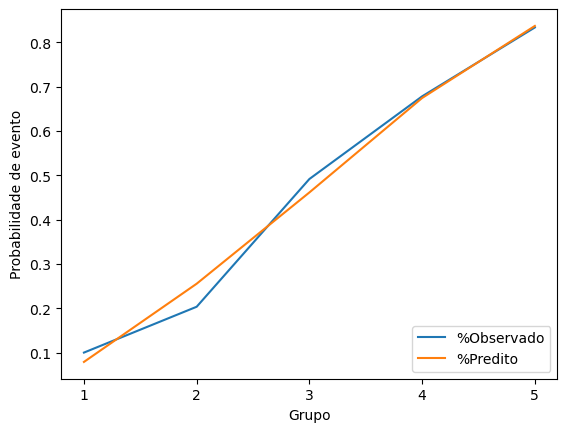

In [292]:
#Comparando graficamente o valor esperado versus observado para a taxa de doentes por grupo:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['doentes'].plot(label='%Observado')
ax = qualid['pred'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [293]:
acc = metrics.accuracy_score(df['flag_doente'], df['pred']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['pred'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'pred'], df.loc[df['flag_doente'] != 1, 'pred']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 78.11%
KS: 57.27% 
AUC: 82.88% 
GINI: 65.76%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [294]:
#Identificando as categorias mais relevantes e transformando em variáveis dummy para manter no modelo:
df['cp_4'] = df.loc[:,'cp'] == 4
df['slope_1_2'] = df.loc[:, 'slope'] != 3
df = df[['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'ca', 'thal', 'num', 'flag_doente',
       'chol_alt', 'cp_4', 'slope_1_2']]
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,num,flag_doente,chol_alt,cp_4,slope_1_2
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,0.0,6.0,0,0,1,False,False
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,3.0,3.0,2,1,1,True,True
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,7.0,1,1,1,True,True
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,0.0,3.0,0,0,1,False,False
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,3.0,0,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,0.0,7.0,1,1,1,True,True
293,45.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,0.0,7.0,1,1,1,False,True
294,68.0,1.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,7.0,2,1,0,True,True
295,57.0,1.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,1.0,7.0,3,1,0,True,True


In [295]:
#Obtendo a regressão logística:
reglog1 = smf.logit('''flag_doente ~ C(sex) +
                                     C(cp_4) +
                                     trestbps +
                                     thalach +
                                     C(exang) +
                                     oldpeak +
                                     ca''', data = df).fit()
reglog1.summary()

Optimization terminated successfully.
         Current function value: 0.357952
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                            9
Date:                Sat, 08 Jul 2023   Pseudo R-squ.:                  0.4813
Time:                        22:22:23   Log-Likelihood:                -106.31
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.206e-37
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.7200      1.937     -1.920      0.055      -7.517       0.077
C(sex)[T.1.0]       1.6093      0.411      3.913      0.000       0.803       2.415
C(cp_4)[T.True]     1.8466      0.384      4.815      0.000       1.095       2.598
C(exang)[T.1.0]     0.8454      0.409      2.067      0.039       0.044       1.647
ca[T.1.0]           1.9205      0.440      4.360      0.000       1.057       2.784
ca[T.2.0]           2.3547      0.598      3.940      0.000       1.183       3.526
ca[T.3.0]           1.9518      0.767      2.545      0.011       0.449       3.455
trestbps            0.0246      0.010      2.480      0.013       0.005       0.044
thalach            -0.0223      0.009     -2.383      0.017      -0.041      -0.004
oldpeak             0.5518      0.182      3.030      0.002       0.195       0.909
===================================================================================
"""

In [296]:
#Adicionando a coluna de valores preditos ao dataframe:
df['pred'] = reglog1.predict(df)
df

C:\Users\alext\AppData\Local\Temp\ipykernel_10592\1787725073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = reglog1.predict(df)


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,num,flag_doente,chol_alt,cp_4,slope_1_2,pred
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,0.0,6.0,0,0,1,False,False,0.347533
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,3.0,3.0,2,1,1,True,True,0.992451
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,7.0,1,1,1,True,True,0.988310
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,0.0,3.0,0,0,1,False,False,0.238236
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,3.0,0,0,1,False,True,0.026717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,0.0,7.0,1,1,1,True,True,0.443795
293,45.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,0.0,7.0,1,1,1,False,True,0.155185
294,68.0,1.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,7.0,2,1,0,True,True,0.987317
295,57.0,1.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,1.0,7.0,3,1,0,True,True,0.977878


In [297]:
#Calculando a calibragem do modelo; categorizando em 5 grupos:
cat_pred1 = pd.qcut(df['pred'], 5, duplicates = 'drop')
cat_pred1.value_counts().sort_index()

(0.0034600000000000004, 0.0617]    60
(0.0617, 0.223]                    59
(0.223, 0.546]                     59
(0.546, 0.912]                     59
(0.912, 0.996]                     60
Name: pred, dtype: int64

In [298]:
#Calculando a probabilidade de evento predita média por grupo:
group_reg1 = df.groupby(cat_pred1)
qualid1 = group_reg1[['flag_doente']].count().rename(columns = {'flag_doente':'count'})
qualid1['pred'] = group_reg1['pred'].mean()
qualid

,count,pred,doentes
pred,,,
"(0.012799999999999999, 0.151]",60,0.078949,0.100000
"(0.151, 0.355]",59,0.255356,0.203390
"(0.355, 0.576]",59,0.461230,0.491525
"(0.576, 0.773]",59,0.674197,0.677966
"(0.773, 0.927]",60,0.836781,0.833333


In [299]:
#Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo:
qualid1['doentes'] = group_reg1['flag_doente'].mean()
qualid

,count,pred,doentes
pred,,,
"(0.012799999999999999, 0.151]",60,0.078949,0.100000
"(0.151, 0.355]",59,0.255356,0.203390
"(0.355, 0.576]",59,0.461230,0.491525
"(0.576, 0.773]",59,0.674197,0.677966
"(0.773, 0.927]",60,0.836781,0.833333


Text(0.5, 0, 'Grupo')

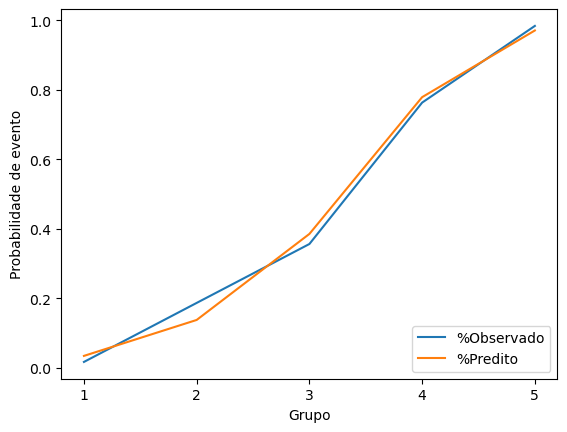

In [300]:
#Comparando graficamente o valor esperado versus observado para a taxa de doentes por grupo:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid1['doentes'].plot(label='%Observado')
ax = qualid1['pred'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

In [301]:
#Calculando a acurácia, KS e Gini do modelo melhorado:
acc = metrics.accuracy_score(df['flag_doente'], df['pred']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['pred'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'pred'], df.loc[df['flag_doente'] != 1, 'pred']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 83.84%
KS: 70.40% 
AUC: 91.93% 
GINI: 83.87%
